# Industrial machinery simulator for AI-enabled IoT scenarios

## Introduction

Implementing a production IoT Predictive Maintenance solution requires having mature remote condition monitoring infrastructure in place. More specifically, data-driven prognostics hinge on the availability of statistically significant amounts of run-to-failure telemetry and maintenance records, from which equipment degradation patterns can be learned to enable failure predications based on both historical and newly collected data.

Real-world run-to-failure data sets are virtually impossible to come across due to their commercially sensitive nature. Of the several publicly available synthetic data sets[[1]](#ref_1)[[2]](#ref_2), none ideally fits the canonical IoT scenario in which highly irregular real-time data streams from sensors are captured and used for condition monitoring or anomaly detection[[3]](#ref_3). For instance, the tiny *Turbofan Engine Degradation Simulation Data Set* [[1]](#ref_1) created with the commercial version of the *Modular Aero-Propulsion System Simulation* environment (C-MAPSS) [[4]](#ref_4) contains a single telemetry snapshot per operational cycle of unspecified length, whereas the data set which accompanies the *Predictive Maintenance Modelling Guide* [[2]](#ref_2) features hourly, presumably aggregated, sensor readings produced by making statistical alterations to uncorrelated series of random numbers. Unfortunately, the source code used for generating these data sets is not publicly available (in fact, obtaining C-MAPSS requires a grant from the U.S. Government). This makes the tasks of converting these data sets to a format which bears more resemblance to that of an IoT-centered scenario and generating new customized data for real-time simulation rather difficult.

The approach to data generation presented in this Notebook is an attempt to simulate a hypothetical IoT-enabled manufacturing environment comprised of generalized rotational equipment, which may include pumps, turbines, gearboxes, compressors, and engines. The end product is a customizable open-source physics-inspired simulation framework which can be used for generating arbitrarily large seed data for model training as well as real-time telemetry streams for performing interactive end-to-end testing and validation of a complete AI-enabled IoT solution. (Suitability for RUL, multiclass classification and failure detection - elaborate.)

## Data inventory

The generated data set will be a combination of maintenance and telemetry records. It is assumed that sensor data, along with the values describing a machine's current operational settings (in this case, rotational speed), is periodically transmitted from an IoT Edge device, with or without preprocessing, to the cloud where it is used for predictive analysis.

### Maintenance and failure records

In the present implementation, the maintenance data set will contain primarily failure events indicating exact points in time when a machine had a critical failure of a particular type. The intent of Predictive Maintenance is preventing these events by raising alarms in advance, so that appropriate preventive activities can be carried out.

#### Format

- timestamp
- level (INFO, WARNING, ERROR, CRITICAL)
- machine ID
- code (identifies event/failure type)
- message (contains additional details)

### Telemetry

This data set will represet an IoT telemetry stream.

#### Format

- timestamp
- machine ID
- ambient temperature (°C)
- ambient pressure (kPa)
- rotational speed (RPM)
- temperature (°C)
- pressure (kPa)
- vibration signal


## Simulation techniques overview (optional)

This section outlines the data generation methodology; it is included for completeness and is not required for understanding the transformations presented in the Notebooks which reference the generated data sets. This topic may be of interest to those who intend to customize, enhance or augment the data for a different scenario. (Skip to data generation for everyone else.)

### Time-varying failure propagation

For the purpose of a physics-inspired data generation, similarly to the approach in *Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation* [[5]](#ref_5), a generalized equation for wear, $w = Ae^{B(t)}$, will be used to model observable phenomena associated with equipment degradation over time.

This generalized wear equation ignores micro-level processes but retains macro-level degradation characteristics. It can be rewritten as a time-varying health index

$$
h(t)=1 - d - exp\{at^b\},
$$

where 

- $d$ is the initial degradation
- $a$ and $b$ are the coefficients defining the trajetory of health loss

Below is an example trajectory of health loss with its characteristic incresingly exponential behavior in the vicinity of a failure.

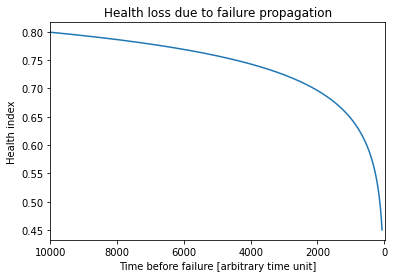

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

t_max = 10000

d = 0.05
a = -0.3
b = 0.2
th = 0.45

def h_generator(ttf, d, a, b, th = 0):
    for t in range(ttf, -1, -1):
        h = 1 - d - math.exp(a*t**b)
        if h < th:
            break
        yield t, h

h = h_generator(t_max, d, a, b, th)

plt.xlim(t_max, -30)
plt.plot(*zip(*h))
plt.title('Health loss due to failure propagation')
plt.ylabel('Health index')
plt.xlabel('Time before failure [arbitrary time unit]')
plt.show()

### Operational settings, operational conditions and performance

*Operational settings* determine the mode of operation and have a substantial effect on the observed performance and other monitored phenomena. For rotational equipment, one of the possible operational settings is the "desired" speed expressed in rotations per minute (RPM). Other operational settings may come into play in real-world scenarios. (For instance, the *Turbofan Engine Degradation Simulation Data Set* [[1]](#ref_1) contains three operational settings.)

*Operational conditions* define the environment in which equipment is being operated. Weather conditions, location, characteristics of the operator are some of the examples. Operational conditions may impact the performance of the equipment and therefore should be taken into account in predictive modeling.

*Performance* is determined by current operational settings, operational conditions and physical state of the equipment (e.g., wear). In this example, performance is expressed as a set of the following sensor measurements:

- speed (actual)
- temperature
- pressure
- vibration

Depending on the type of the equipment, some sensors will measure useful output, and some the side effects of mechanical or other processes (or, in energy terms, the loss). Most of the time, upcoming failures manifest themselves in a gradually diminishing useful output and increased loss under some or all operational settings; for example, assuming that pressure is considered "useful output," a machine operating at the same speed would generate increasingly less pressure while, possibly, also producing more heat or vibration. Performance measurements often exhibit some complex nonlinear behavior with respect to operational settings, operational conditions and equipment health.

The general idea behind Predictive Maintenance is that different types of impending failures manifest themselves in different ways over time, and that such patterns can be learned given sufficient amount of collected data.

### Simulation explained

Several different failure modes due to unspecified physical damage will be simulated by imposing independent time-varying health indices, $h_i(t)$, with randomly chosen failure propagation parameters ($a_i$, $b_i$). Each of the $N$ simulated devices will start with a random non-zero initial deterioration to account for variations due to age, manufacturing defects and other unknown factors.

Each device will be simulated under a randomized sequence of changing over time operational settings (speed in this case), producing telemetry time series containing all observable performance and operational measurements impacted by the current values of the health indices. Whenever any of the health indices drops below its threshold (a value dependent on the failure mode), a correspoinding record will be added to the maintenance log.

All generated telemetry data will be contaminated with sensor noise.

#### Operational settings

At any point in time, a rotational machine has a certain desired speed expressed in revolutions per minute (RPM). This speed can vary (i.e., the engine may start, stop, gradually accelerate or decelerate) or be relatively static.

The example below demonstrates how smooth variations over time can be modeled by means of cubic or linear interpolation.

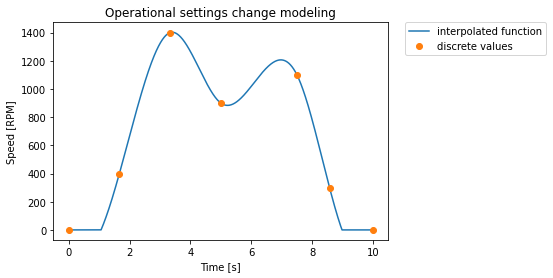

In [2]:
from scipy.interpolate import interp1d

t_max = 10 # (seconds)
sample_rate = 2**10 # ~1kHz

t = np.linspace(0, t_max, num = t_max * sample_rate, endpoint = False)

x = [0, t_max / 6, t_max / 3, t_max /2, t_max * 3 / 4 ,t_max * 6 / 7, t_max] # points in time
values = np.array([0, 400, 1400, 900, 1100, 300, 0]) # speeds at the given points in time

values_interpolated = interp1d(x, values, kind='cubic') # choosing 'linear' will produce a piecewise function

omega = values_interpolated(t)

# interpolation is not positive-preserving
omega[omega < 0] = 0

plt.title('Operational settings change modeling')
plt.ylabel('Speed [RPM]')
plt.xlabel('Time [s]')
plt.plot(t, omega, label = 'interpolated function')
plt.plot(x, values, 'o', label = 'discrete values')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

#### Sensor measurements

Based on momentary values of the health indices, operational settings (speed) and operational conditions (ambient temperature, pressure), sensor measurements can be simulated in a "stroboscopic" fashion as time-varying functions.

##### Temperature and pressure

Instant temperature and pressure (generalized as $F(t)$ below) depend on
- the current operational setting, $\omega$
- the previous value, $F(t-1)$
- current health indices, $h^*(t)$
- ambient conditions, $a^*(t)$

$$
F(t) = f(\omega, F(t-1), h^*(t), a^*(t))
$$

Real-world simulators, like C-MAPSS, solve differential equations to model a system's evolution over time. Here, for the purpose of generating somewhat realistic data, a simplistic iterative method will suffice.

##### Vibration
*Vibration* and *acoustic* analyses are essential tools for monitoring the health of mechanical equipment. As the presenter in the video [[6]](#ref_6) explains, its about "giving machines a voice so we can listen and determine if the machine needs attention". The blog post [[7]](#ref_7) provides insights into some of the existing vibration monitoring equipment. These non-invasively mounted sensors (usually, piezoelectric accelerometers) collect typically one-dimentional analog signal representing the vibration at a certain spot and periodically transmit it to an Edge device or directly to the Cloud.

For rotational equipment, frequencies of harmonic components of the vibration signal can be modeled as multiples of the machine's speed (i.e., the fundamental frequency). Continuous vibration or sound signal can be simulated by means of spectral modeling synthesis:

- simulating vibration signal with a static fundamental frequency
$$
S(t) = \sum_k A_k\sin(2\pi f_kt)
$$

- performing frequency modulation when simulating vibration signal with a time-varying fundamental frequency
$$
S(t) = \sum_k{A_k\sin(2\pi \int_0^t{f_k(t)dt)}}
$$

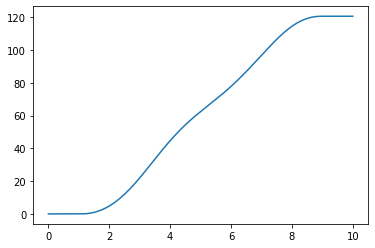

In [3]:
fi = np.cumsum(omega/sample_rate)/60
plt.plot(t, fi)
plt.show()

In [4]:
from IPython.display import Audio
from scipy import signal

w_normal = [1, 2, 3, 4, 5, 12, 15]
A_normal = [5, 8, 2/3, 9, 8, 13, 5]

def generate(fi, wk, Ak, s = None):
    N = len(fi)
    base = 2 * np.pi * fi
    b = np.array([np.sin(base * w) * a for w, a in zip(wk, Ak)])
    a = b.sum(axis = 0)
    a = np.random.normal(-0.1, 0.1, N) + a
    if s is not None:
        a += s
    return np.int16(a/np.max(np.abs(a)) * 32767)

signal_pcm = generate(fi, w_normal, A_normal)

def as_audio(signal_pcm, sample_rate = sample_rate):
    audio_sample_rate = 8192
    if sample_rate != audio_sample_rate:
        signal_pcm = signal.resample(signal_pcm, len(signal_pcm) * int(audio_sample_rate / sample_rate))
    return Audio(signal_pcm, rate = audio_sample_rate , autoplay=False)
    
as_audio(signal_pcm)

/var/folders/7_/5nn0hhzd0mgcwwd1975014840000gn/T/ipykernel_68232/1655208801.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cmap.set_under(color='k', alpha=None)


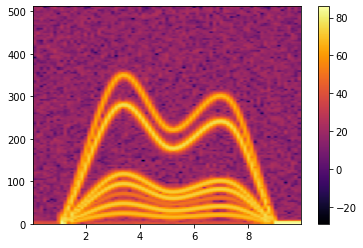

In [5]:
def spectrogram(signal, sample_rate):
    fig, ax = plt.subplots()
    cmap = plt.get_cmap('inferno')
    cmap.set_under(color='k', alpha=None)
    Pxx, freqs, bins, im = ax.specgram(signal, Fs=sample_rate, NFFT=256, cmap = cmap, mode='magnitude')
    fig.colorbar(im)
    plt.show()
    
spectrogram(signal_pcm, sample_rate)

Nyquist frequency (i.e., half the sampling frequency) [[8]](#ref_8)

## Data generation

In order to produce a sufficiently large simulated dataset that resembles a possible real-world scenario for model training, and also to demonstrate how the model performs in a fully operationalized environment, we will develop a method for simulating sensor data that could have been collected from some sort of rotating machinery.

In [6]:
%%writefile simulation.py
import numpy as np
import random
from datetime import date
from scipy.interpolate import interp1d

class VibrationSensorSignalSample:
    CUTOFF = 150

    def __init__(self, W, A, fundamental_from, fundamental_to, t = 0, interval = 1, previous_sample = None, sample_rate = 1024):
        self.interval = interval
        self.sample_rate = sample_rate
        self.W = W
        self.A = A
        self.t = t
        self.base_frequency = fundamental_from
        self.target_base_frequency = fundamental_to
        self.add_noise = True
        self.__previous_sample = previous_sample
        self.__N = sample_rate * interval

    def pcm(self):
        ts = np.linspace(self.t, self.t + self.interval, num = self.__N, endpoint=False)

        x = np.array([0, self.interval]) + self.t
        points = np.array([self.base_frequency, self.target_base_frequency])
        rpm = interp1d(x, points, kind='linear')

        f = rpm(ts)
        f[f < 0] = 0

        fi = np.cumsum(f / self.sample_rate) + (self.__previous_sample.__last_cumsum if self.__previous_sample else 0)

        base = 2 * np.pi * fi
        b = np.array([np.sin(base * w) * a for w, a in zip(self.W, self.A)])
        a = b.sum(axis = 0)

        if self.add_noise:
            a += np.random.normal(0, 0.1, self.__N)

        self.__last_cumsum = fi[-1]
        self.base_frequency = self.target_base_frequency

        a[a > self.CUTOFF] = self.CUTOFF
        a[a < -self.CUTOFF] = -self.CUTOFF

        return np.int16(a / self.CUTOFF * 32767)

class RotationalMachine:
    ambient_temperature = 20 # degrees Celsius
    max_temperature = 120
    ambient_pressure = 101 # kPa

    def __init__(self, name, h1, h2):
        self.W = [1/2, 1, 2, 3, 5, 7, 12, 18]
        self.A = [1, 5, 80, 2/3, 8, 2, 14, 50]
        self.t = 0
        self.name = name
        self.speed = 0
        self.speed_desired = 0
        self.temperature = RotationalMachine.ambient_temperature
        self.pressure = RotationalMachine.ambient_pressure
        self.pressure_factor = 2
        self.__vibration_sample = None
        self.__h1 = h1
        self.__h2 = h2
        self.broken = False
        
    def set_health(self, h1, h2):        
        self.__h1 = h1
        self.__h2 = h2
        self.broken = False

    def set_speed(self, speed):
        self.speed_desired = speed

    def __g(self, v, min_v, max_v, target, rate):
        delta = (target - v) * rate
        return max(min(v + delta, max_v), min_v)
    
    def noise(self, magnitude):
        return random.uniform(-magnitude, magnitude)

    def next_state(self):
        try:
            _, h1 = next(self.__h1)
        except:
            self.broken = True
            raise Exception("F1")
        
        try:
            _, h2 = next(self.__h2)
        except:
            self.broken = True
            raise Exception("F2")
            
        v_from = self.speed / 60        
        self.speed = (self.speed + (2 - h2) * self.speed_desired) / 2
        v_to = self.speed / 60
        
        self.temperature = (2 - h1) * self.__g(self.temperature, self.ambient_temperature, self.max_temperature, self.speed / 10, 0.01 * self.speed / 1000)
        self.pressure = h1 * self.__g(self.pressure, self.ambient_pressure, np.inf, self.speed * self.pressure_factor, 0.3 * self.speed / 1000)        
        self.__vibration_sample = VibrationSensorSignalSample(
            #self.W, self.A, v_from, v_to, t = self.t, previous_sample = self.__vibration_sample)
            self.W, self.A, v_from, v_to, t = self.t)
       
        state = {
            'speed_desired': self.speed_desired,
            'ambient_temperature': self.ambient_temperature + self.noise(0.1),
            'ambient_pressure': self.ambient_pressure + self.noise(0.1),
            'speed': self.speed + self.noise(5),
            'temperature': self.temperature + self.noise(0.1),
            'pressure': self.pressure + self.noise(20),
            'vibration': self.__vibration_sample
        }
        
        self.t += 1

        for key in state:
            value = state[key]
            if isinstance(value, (int, float)):                
                state[key] = round(value, 2)

        return state

Overwriting simulation.py


In [7]:
from pathlib import Path
data_dir = str(Path.home()) + '/data'
print(data_dir)

/Users/briannguyen/data


In [39]:
%rm -rf $data_dir
%mkdir $data_dir $data_dir/logs $data_dir/telemetry

import time
import random
import datetime
import pandas as pd
from dateutil import parser
from ipywidgets import IntProgress

# this forces IPython to load the latest version
# of the simulation module
import importlib
# https://docs.python.org/3/library/importlib.html#importlib.invalidate_caches
importlib.invalidate_caches()
import simulation
importlib.reload(simulation)
from simulation import RotationalMachine

# Simulation parameters
seed = 42
date_from = parser.parse("January 1 2021 12:00AM")
date_to = parser.parse("January 1 2022 12:00AM")
telemetry_batch_frequency = datetime.timedelta(hours = 1)
telemetry_interval = datetime.timedelta(seconds = 1)
machine_count = 1000
active_machines_per_batch = 33
cycle_length_min = 1
cycle_length_max = 3

random.seed(seed)

def create_machines(n):
    machines = []
    for i in range(n):
        ttf1 = random.randint(5000, 50000)
        ttf2 = random.randint(5000, 90000)
        
        h1 = h_generator(ttf1, d, a, b)
        h2 = h_generator(ttf2, d, a, b)
        
        m = RotationalMachine('M_{0:04d}'.format(i), h1, h2)
        machines.append(m)
    return machines

def sample(machines, m):
    return [machines[i] for i in sorted(random.sample(range(len(machines)), m))]

machines = create_machines(machine_count)

telemetry = []
errors = []

max_count = (date_to - date_from) / telemetry_batch_frequency
f = IntProgress(min=0, max=max_count, description='Simulation:') # instantiate the bar
display(f)
while date_from + telemetry_batch_frequency < date_to:
    s = sample(machines, active_machines_per_batch)
    telemetry.clear()

    for m in s:
        if m.broken:
            # repair record
            ttf1 = random.randint(5000, 50000)
            h1 = h_generator(ttf1, d, a, b)
            
            ttf2 = random.randint(5000, 90000)
            h2 = h_generator(ttf2, d, a, b)
            m.set_health(h1, h2)
            
            errors.append({
                'timestamp': date_from,
                'machineID': m.name,
                'level': 'INFO',
                'code': 'fixed'
            })

            continue
            
        l = random.randint(cycle_length_min, cycle_length_max)
        offset = random.randint(0, 60-l)
        m.set_speed(1000)
        duration = l * 60
        cooldown_point = duration - 20
        for i in range(duration):
            if i == cooldown_point:
                m.set_speed(0)
                
            ts = date_from + datetime.timedelta(seconds=offset * 60 + i)
            try:
                state = m.next_state()
                state['timestamp'] = ts
                state['machineID'] = m.name
                telemetry.append(state)
                if not state['speed']:
                    break
            except Exception as e:
                errors.append({
                    'timestamp': ts,
                    'machineID': m.name,
                    'level': 'CRITICAL',
                    'code': str(e)
                })
                break

    if telemetry:
        telemetry_df = pd.DataFrame(telemetry).drop('vibration', axis = 1)
        telemetry_df.index = telemetry_df['timestamp']
        del telemetry_df['timestamp']
        suffix = date_from.strftime("%Y%m%d-%H%M%S")
        # INT96 timestamp are deprecated, but default INT64 timestamps are supported only since Spark 2.3.0
        telemetry_df.to_parquet('{0}/telemetry/telemetry-{1}.parquet'.format(data_dir, suffix), engine='fastparquet', times='int96')
        del telemetry_df        
        
    date_from += telemetry_batch_frequency
    f.value += 1
    
if errors:
    logs_df = pd.DataFrame(errors)
    sequence_count = len(logs_df[logs_df.level == 'CRITICAL'])
    logs_df.index = logs_df['timestamp']
    del logs_df['timestamp']
    logs_df.to_parquet(data_dir + '/logs/logs.parquet', engine='fastparquet', times='int96')
    print('{0} run-to-failure sequence(s) generated.'.format(sequence_count))
else:
    print('WARNING: Simulation produced no run-to-failure sequences.')

IntProgress(value=0, description='Simulation:', max=8760)

1082 run-to-failure sequence(s) generated.


## References

https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/

https://github.com/Microsoft/SQL-Server-R-Services-Samples/tree/master/PredictiveMaintanenceModelingGuide

https://download.microsoft.com/download/B/6/0/B6037562-B22C-4855-B6EF-8535C1880075/Capture_value_from_the_Internet%20of%20Things_with_Remote_Monitoring.PDF

https://www.grc.nasa.gov/WWW/cdtb/software/mapss.html

https://ti.arc.nasa.gov/m/pub-archive/154/154_Saxena.pdf

https://www.youtube.com/watch?v=rLpKnx0pUEE

https://blog.mide.com/6-ways-to-measure-vibrations

<a name="ref_8"></a>8.  [Digital Signal Processing Using MATLAB for Students and Researchers](https://books.google.com/books?id=Qtd-e1NtZVkC&pg=PA82#v=onepage&q&f=false). John Wiley & Sons. p. 82. ISBN 9781118033807. "The Nyquist rate is twice the bandwidth of the signal ... The Nyquist frequency or folding frequency is half the sampling rate and corresponds to the highest frequency which a sampled data system can reproduce without error."